### Introduction to Differential Privacy with Randomized Response

In this notebook, we'll take a *very simple* view of differential privacy to try and implement a basic boolean (yes, no) randomized response. We will then investigate the measurement of epsilon for our response and evaluate the aggregate statistics of our implementation on several distributions.

For further investigation into differential privacy guarantees and implmentations, please see the in-depth notebook included in this repository alongside these further references:

- TODO

## Defining Differential Privacy

[Differential privacy](https://www.microsoft.com/en-us/research/publication/differential-privacy/) is a popular mechanism to quantitatively assess the privacy loss of a given probabilistic query schema or data transformation method. The fundamental equation of differntial privacy is given as

$$ 
\begin{equation}
    \mathrm{Pr}[\mathcal{K}(D_1) \in S] \le exp(\epsilon) \times \mathrm{Pr}[\mathcal{K}(D_2) \in S] \label{eq:dp}
\end{equation}
$$

Here, $\mathrm{Pr}[\mathcal{K}(D_1) \in S]$ is the probability of a
randomized function $\mathcal{K}$ to yield one of values in the $S$ when evaluating
it on a given dataset $D_1$. The right side is identical to the left except
that the function is now evaluated on a dataset $D_2$ that differs from $D_1$
in at most one element. And finally, $\epsilon$ is a parameter that describes
how much information is leaked (or generated) by the function.

But how might this work in practice? We can think of one simple implementation, which is randomized response. With randomized response we are able to return the true value with some probability. We can think of this like a coin-flip. Let's say we want to ask something where only one response might be seen as sensitive, such as: Have you ever stolen something? 

We might say to the respondents, flip a coin. If the flip turns up heads, say yes no matter what. Otherwise, say the true answer. This gives each individual respondent some guarantee of individual privacy (and plausable deniability).


In [19]:
from random import random, choice
from matplotlib import pylab as pl

def simple_randomized_response(prob, value):
    """With probability `prob` return the true value, 
       val -- otherwise return 1.
    """
    if random() <= prob:
        return value
    return 1

In [27]:
simulated, real = [], []

while len(simulated) < 1000:
    real_val = choice([0,1, 0, 0])
    real.append(real_val)
    simulated.append(simple_randomized_response(.5, real_val))

## Your Turn: How many from our simulated runs answered truthfully?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106d22a58>,
      dtype=object)

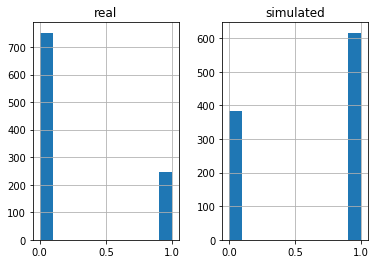

In [28]:
import pandas as pd
pd.DataFrame({'real': real, 'simulated': simulated}).hist()

### How might we estimate the true distribution when given only the randomized response?

In [29]:
prob = .5

estimate = []
for sim in simulated:
    if sim == 1 and random() <= prob:
        estimate.append(0)
    else:
        estimate.append(1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106d2cc18>,
      dtype=object)

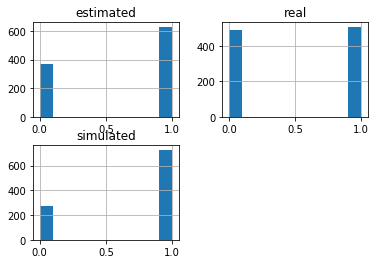

In [26]:
import pandas as pd
pd.DataFrame({'real': real, 'simulated': simulated, 
              'estimated': estimate}).hist()

### Your Turn: How would this change if we had a different real distribution?

- Can you run an experiment by modifying the outcome above?
- How might your estimate change if you have knowledge of the population distribution?

#### Calculating $\epsilon$

In our differentially private scheme, the probability of adding the true attribute value to the database is $1-p$. The probability of adding a random value is therefore $p$ and the probability of that value being $0$ is $k$. So how can we relate this to our initial definition of differential privacy? Well, we can set $D_1$ and $D_2$ as the versions of our database **before** and **after** adding the person's data to it. Let's say that before adding the person's data there are $n$ $1$'s in the database. We can then use a query $\mathcal{K}$ that returns the number of 1's in the database and choose our result set as $S = \{n\}$. Before adding the person to the database, $\mathcal{K}(D_1)=n$ with certainty, hence $\mathrm{Pr}(\mathcal{K}(D_1))=1$. After adding the person's data, the probability that the query result is still $n$ can be calculated as follows, depending on the person's attribute value:

* If a persons's attribute value is $0$, the probability that $\mathcal{K}$ is unchanged after adding the data to the database is given as $1-p+p\cdot k$.
* If a person's attribute value is $1$, the probability that $\mathcal{K}$ is unchanged after adding the data to the database is given as $p\cdot k$.

We therefore have the two equations

$$
\begin{eqnarray}
\mathrm{Pr}[\mathcal{K}(D_1) \in S | x_i=1] & = & 1 \le \exp{\epsilon}\cdot \mathrm{Pr}[\mathcal{K}(D_2) \in S | x_i=1] = \exp{\epsilon}\cdot p \cdot k \\
\mathrm{Pr}[\mathcal{K}(D_1) \in S | x_i=0] & = & 1 \le \exp{\epsilon}\cdot \mathrm{Pr}[\mathcal{K}(D_2) \in S | x_i=0] = \exp{\epsilon}\cdot (1-p+p \cdot k) \\
\end{eqnarray}
$$

This yields

$$
\begin{eqnarray}
 \epsilon & \ge & -\ln{\left(p \cdot k\right)} \\
 \epsilon & \ge & -\ln{\left(1-p+p\cdot k\right)} \\
\end{eqnarray}
$$

Since we're interested in an upper bound for $\epsilon$ and since $-\ln{\left(1-p+p\cdot k\right)} \le -\ln{p\cdot k}$, we obtain

$$
\begin{equation}
\epsilon = -\ln{\left(p\cdot k\right)}
\end{equation}
$$

In [30]:
# %load "../solutions/differential-privacy/epsilon.py"
import numpy as np

def epsilon(p, k):
    """
    :param p: The probability of returning a random value instead of the true one
    :param k: The probability of returning 1 when generating a random value
    :returns: The epsilon for the given values of p, k
    """
    return -np.log(p*k)

In [32]:
# so in our case...

epsilon(.5, 1)

0.6931471805599453

In [35]:
np.exp(epsilon(.5, 1))

2.0

### Protecting both responses

- What about if either response was sensitive, and we needed to protect both yes and no?
- How about if our response was not a simple yes or no; but instead multidimensional data?
- What if we want to query a person over a longer period of time?